In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Multi-Modal Data Training with TensorFlow

This notebook is similar to https://github.com/NVIDIA/NVTabular/blob/main/examples/getting-started-movielens/03-Training-with-TF.ipynb, except for we make use of pretrained embeddings. 

## Overview

We observed that TensorFlow training pipelines can be slow as the dataloader is a bottleneck. The native dataloader in TensorFlow randomly sample each item from the dataset, which is very slow. The window dataloader in TensorFlow is not much faster. In our experiments, we are able to speed-up existing TensorFlow pipelines by 9x using a highly optimized dataloader.<br><br>

Applying deep learning models to recommendation systems faces unique challenges in comparison to other domains, such as computer vision and natural language processing. The datasets and common model architectures have unique characteristics, which require custom solutions. Recommendation system datasets have terabytes in size with billion examples but each example is represented by only a few bytes. For example, the [Criteo CTR dataset](https://ailab.criteo.com/download-criteo-1tb-click-logs-dataset/), the largest publicly available dataset, is 1.3TB with 4 billion examples. The model architectures have normally large embedding tables for the users and items, which do not fit on a single GPU. You can read more in our [blogpost](https://medium.com/nvidia-merlin/why-isnt-your-recommender-system-training-faster-on-gpu-and-what-can-you-do-about-it-6cb44a711ad4).

### Learning objectives

This notebook explains, how to use the NVTabular dataloader to accelerate TensorFlow training.
1. Use **NVTabular dataloader** with TensorFlow Keras model
2. Leverage **multi-hot encoded input features**

## NVTabular dataloader for TensorFlow

We’ve identified that the dataloader is one bottleneck in deep learning recommender systems when training pipelines with TensorFlow. The dataloader cannot prepare the next batch fast enough and therefore, the GPU is not fully utilized. 

We developed a highly customized tabular dataloader for accelerating existing pipelines in TensorFlow. In our experiments, we see a speed-up by 9x of the same training workflow with NVTabular dataloader. NVTabular dataloader’s features are:
- removing bottleneck of item-by-item dataloading
- enabling larger than memory dataset by streaming from disk
- reading data directly into GPU memory and remove CPU-GPU communication
- preparing batch asynchronously in GPU to avoid CPU-GPU communication
- supporting commonly used .parquet format
- easy integration into existing TensorFlow pipelines by using similar API - works with tf.keras models

More information in our [blogpost](https://medium.com/nvidia-merlin/training-deep-learning-based-recommender-systems-9x-faster-with-tensorflow-cc5a2572ea49).

In [2]:
# External dependencies
import os
import glob

import nvtabular as nvt
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

We define our base input directory, containing the data.

In [3]:
INPUT_DATA_DIR = './data'
# path to save the models
MODEL_BASE_DIR = './models'

### Defining Hyperparameters

First, we define the data schema and differentiate between single-hot and multi-hot categorical features. Note, that we do not have any numerical input features. 

In [4]:
BATCH_SIZE = 1024
CATEGORICAL_COLUMNS = ["movie_id", "user_id"]  # Single-hot
CATEGORICAL_MH_COLUMNS = ["genre"]  # Multi-hot
NUMERIC_COLUMNS = []

# Output from ETL-with-NVTabular
TRAIN_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, "valid", "*.parquet")))

In [5]:
TRAIN_PATHS

['./data/train/part_0.parquet']

In the previous notebook, we used NVTabular for ETL and stored the workflow to disk. We can load the NVTabular workflow to extract important metadata for our training pipeline.

In [6]:
workflow = nvt.Workflow.load(os.path.join(INPUT_DATA_DIR, "workflow"))

The embedding table shows the cardinality of each categorical variable along with its associated embedding size. Each entry is of the form `(cardinality, embedding_size)`.

In [7]:
nvt.ops.get_embedding_sizes(workflow)

({'user_id': (944, 74), 'movie_id': (1645, 101)}, {'genre': (20, 16)})

In [8]:
EMBEDDING_TABLE_SHAPES, MH_EMBEDDING_TABLE_SHAPES = nvt.ops.get_embedding_sizes(workflow)
EMBEDDING_TABLE_SHAPES.update(MH_EMBEDDING_TABLE_SHAPES)
EMBEDDING_TABLE_SHAPES

{'user_id': (944, 74), 'movie_id': (1645, 101), 'genre': (20, 16)}

### Initializing NVTabular Dataloader for Tensorflow

We import TensorFlow and some NVTabular TF extensions, such as custom TensorFlow layers supporting multi-hot and the NVTabular TensorFlow data loader.

In [9]:
#!pip install tensorflow-gpu==2.4.0

In [10]:
import os
import tensorflow as tf

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ["TF_MEMORY_ALLOCATION"] = "0.7"  # fraction of free memory
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers

2022-05-26 04:24:14.941826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 04:24:14.942302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 04:24:14.942478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


First, we take a look on our data loader and how the data is represented as tensors. The NVTabular data loader are initialized as usually and we specify both single-hot and multi-hot categorical features as cat_names. The data loader will automatically recognize the single/multi-hot columns and represent them accordingly.

In [11]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS,  # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=["rating"],
    cat_names=CATEGORICAL_COLUMNS + CATEGORICAL_MH_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine="parquet",
    shuffle=True,
    buffer_size=0.06,  # how many batches to load at once
    parts_per_chunk=1,
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS,  # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=["rating"],
    cat_names=CATEGORICAL_COLUMNS + CATEGORICAL_MH_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine="parquet",
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1,
)

/usr/local/lib/python3.8/dist-packages/cudf/core/dataframe.py:1292: UserWarning: The deep parameter is ignored and is only included for pandas compatibility.
  warnings.warn(


In [12]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS,  # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=["rating"],
    cat_names=CATEGORICAL_COLUMNS + CATEGORICAL_MH_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine="parquet",
    shuffle=True,
    buffer_size=0.06,  # how many batches to load at once
    parts_per_chunk=1,
)

In [13]:
batch = next(iter(train_dataset_tf))
batch[0]

2022-05-26 04:24:15.154299: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-26 04:24:15.155049: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 04:24:15.155223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 04:24:15.155353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

{'genre': (<tf.Tensor: shape=(2195, 1), dtype=int64, numpy=
  array([[3],
         [6],
         [7],
         ...,
         [3],
         [2],
         [8]])>,
  <tf.Tensor: shape=(1024, 1), dtype=int32, numpy=
  array([[4],
         [2],
         [1],
         ...,
         [4],
         [2],
         [3]], dtype=int32)>),
 'movie_id': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
 array([[201],
        [ 64],
        [586],
        ...,
        [ 36],
        [ 13],
        [447]])>,
 'user_id': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
 array([[134],
        [684],
        [151],
        ...,
        [290],
        [ 93],
        [ 29]])>}

In [14]:
type(batch[0]['genre'])

tuple

In [15]:
from nvtabular.framework_utils.tensorflow import layers

Let's generate a batch and take a look on the input features.<br><br>
We can see, that the single-hot categorical features (`user_id` and `movie_id`) have a shape of `(1024, 1)`, which is the batchsize.<br><br>
For the multi-hot categorical feature `genre`, we receive two Tensors `genre__values` and `genre__nnzs`.<br><br>
`genre__values` are the actual data, containing the genre IDs. Note that the Tensor has more values than the batch_size. The reason is, that one datapoint in the batch can contain more than one genre (multi-hot).<br>
`genre__nnzs` are a supporting Tensor, describing how many genres are associated with each datapoint in the batch.<br><br>
For example,
- if the first value in `genre__nnzs` is `5`, then the first 5 values in `genre__values` are associated with the first datapoint in the batch (movieId/userId).<br>
- if the second value in `genre__nnzs` is `2`, then the 6th and the 7th values in `genre__values` are associated with the second datapoint in the batch (continuing after the previous value stopped).<br> 
- if the third value in `genre_nnzs` is `1`, then the 8th value in `genre__values` are associated with the third datapoint in the batch. 
- and so on

In [16]:
batch = next(iter(train_dataset_tf))
batch[0]

{'genre': (<tf.Tensor: shape=(2199, 1), dtype=int64, numpy=
  array([[ 1],
         [ 7],
         [ 4],
         ...,
         [15],
         [ 9],
         [ 1]])>,
  <tf.Tensor: shape=(1024, 1), dtype=int32, numpy=
  array([[3],
         [4],
         [2],
         ...,
         [2],
         [3],
         [2]], dtype=int32)>),
 'movie_id': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
 array([[230],
        [291],
        [462],
        ...,
        [348],
        [256],
        [153]])>,
 'user_id': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
 array([[738],
        [ 35],
        [  8],
        ...,
        [289],
        [  4],
        [178]])>}

We can see that the sum of `genres__nnzs` is equal to the shape of `genres__values`.

In [17]:
tf.reduce_sum(batch[0]['genre'][1])

<tf.Tensor: shape=(), dtype=int32, numpy=2199>

As each datapoint can have a different number of genres, it is more efficient to represent the genres as two flat tensors: One with the actual values (`genres__values`) and one with the length for each datapoint (`genres__nnzs`).

In [18]:
del batch

### Defining Neural Network Architecture

We will define a common neural network architecture for tabular data.
* Single-hot categorical features are fed into an Embedding Layer
* Each value of a multi-hot categorical features is fed into an Embedding Layer and the multiple Embedding outputs are combined via averaging
* The output of the Embedding Layers are concatenated
* The concatenated layers are fed through multiple feed-forward layers (Dense Layers with ReLU activations)
* The final output is a single number with sigmoid activation function

First, we will define some dictonary/lists for our network architecture.

In [19]:
inputs = {}  # tf.keras.Input placeholders for each feature to be used
emb_layers = []  # output of all embedding layers, which will be concatenated

We create `tf.keras.Input` tensors for all 4 input features.

In [20]:
CATEGORICAL_COLUMNS

['movie_id', 'user_id']

In [21]:
for col in CATEGORICAL_COLUMNS:
    inputs[col] = tf.keras.Input(name=col, dtype=tf.int32, shape=(1,))
# Note that we need two input tensors for multi-hot categorical features
for col in CATEGORICAL_MH_COLUMNS:
    inputs[col + "__values"] = tf.keras.Input(name=f"{col}__values", dtype=tf.int64, shape=(1,))
    inputs[col + "__nnzs"] = tf.keras.Input(name=f"{col}__nnzs", dtype=tf.int64, shape=(1,))

In [22]:
tf.keras.layers.Reshape(())(inputs['movie_id'])

<KerasTensor: shape=(None,) dtype=int32 (created by layer 'reshape')>

Next, we initialize Embedding Layers with `tf.feature_column.embedding_column`.

In [23]:
for col in CATEGORICAL_COLUMNS + CATEGORICAL_MH_COLUMNS:
    emb_layers.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(
                col, EMBEDDING_TABLE_SHAPES[col][0]
            ),  # Input dimension (vocab size)
            EMBEDDING_TABLE_SHAPES[col][1],  # Embedding output dimension
        )
    )
emb_layers

[EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='movie_id', number_buckets=1645, default_value=None), dimension=101, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcfe422db50>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='user_id', number_buckets=944, default_value=None), dimension=74, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcfe422db80>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='genre', number_buckets=20, default_value=None), dimension=16, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7fcfe422dc10>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None,

## Loading pretrained movie features into non-trainable embedding layer

In [24]:
import pandas as pd
import cudf
import numpy as np

movie_features = pd.read_pickle('data/movies_poster_features.pkl')

During preprocessing, original movie ids got mapped to a continuous list of integers. We now need to reconstruct this mapping to assign each embedding to correct id.

In [25]:
movie_id_mapping = cudf.read_parquet('data/workflow/categories/unique.movie_id.parquet')
emb_row_idx2movie_id = movie_id_mapping.loc[1:, 'movie_id'].to_pandas().to_dict()
movie_id2emb_row_idx ={v:k for k,v in emb_row_idx2movie_id.items()}

Equipped with this information, we can now construct the embedding table.

In [26]:
num_embeddings = len(movie_id_mapping)
embedding_dim = 2048

# Prepare embedding matrix
embedding_matrix = np.zeros((num_embeddings, embedding_dim))

for movie_id, poster_features in movie_features.items():
    if movie_id in movie_id2emb_row_idx: # movies that have not found their way into the train set will not be in this mapping
        embedding_matrix[movie_id2emb_row_idx[movie_id]] = poster_features

In [27]:
from tensorflow.keras.layers import Embedding
import keras

feature_embedding_layer = Embedding(
    num_embeddings,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [28]:
pretrained_feature = feature_embedding_layer(tf.keras.layers.Reshape(())(inputs['movie_id']))

In [29]:
pretrained_feature

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'embedding')>

In [30]:
EMBEDDING_TABLE_SHAPES

{'user_id': (944, 74), 'movie_id': (1645, 101), 'genre': (20, 16)}

NVTabular implemented a custom TensorFlow layer `layers.DenseFeatures`, which takes as an input the different `tf.Keras.Input` and pre-initialized `tf.feature_column` and automatically concatenate them into a flat tensor. In the case of multi-hot categorical features, `DenseFeatures` organizes the inputs `__values` and `__nnzs` to define a `RaggedTensor` and combine them. `DenseFeatures` can handle numeric inputs, as well, but MovieLens does not provide numerical input features.

In [233]:
?? layers.DenseFeatures

In [218]:
from tensorflow.keras import layers as keras_layers

emb_layer = layers.DenseFeatures(emb_layers)
x_emb_output = keras_layers.concatenate((emb_layer(inputs), pretrained_feature))
x_emb_output

RuntimeError: Exception encountered when calling layer "dense_features" (type DenseFeatures).

KeyError: 'genre'

Call arguments received:
  • inputs={'movie_id': 'tf.Tensor(shape=(None, 1), dtype=int32)', 'user_id': 'tf.Tensor(shape=(None, 1), dtype=int32)', 'genre__values': 'tf.Tensor(shape=(None, 1), dtype=int64)', 'genre__nnzs': 'tf.Tensor(shape=(None, 1), dtype=int64)'}

We can see that the output shape of the concatenated layer is equal to the sum of the individual Embedding output dimensions (1040 = 16+512+512).


In [128]:
EMBEDDING_TABLE_SHAPES

{'movieId': (56586, 512), 'userId': (162542, 512), 'genres': (21, 16)}

We add multiple Dense Layers. Finally, we initialize the `tf.keras.Model` and add the optimizer.

In [129]:
x = tf.keras.layers.Dense(128, activation="relu")(x_emb_output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile("adam", "binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="AUC")])

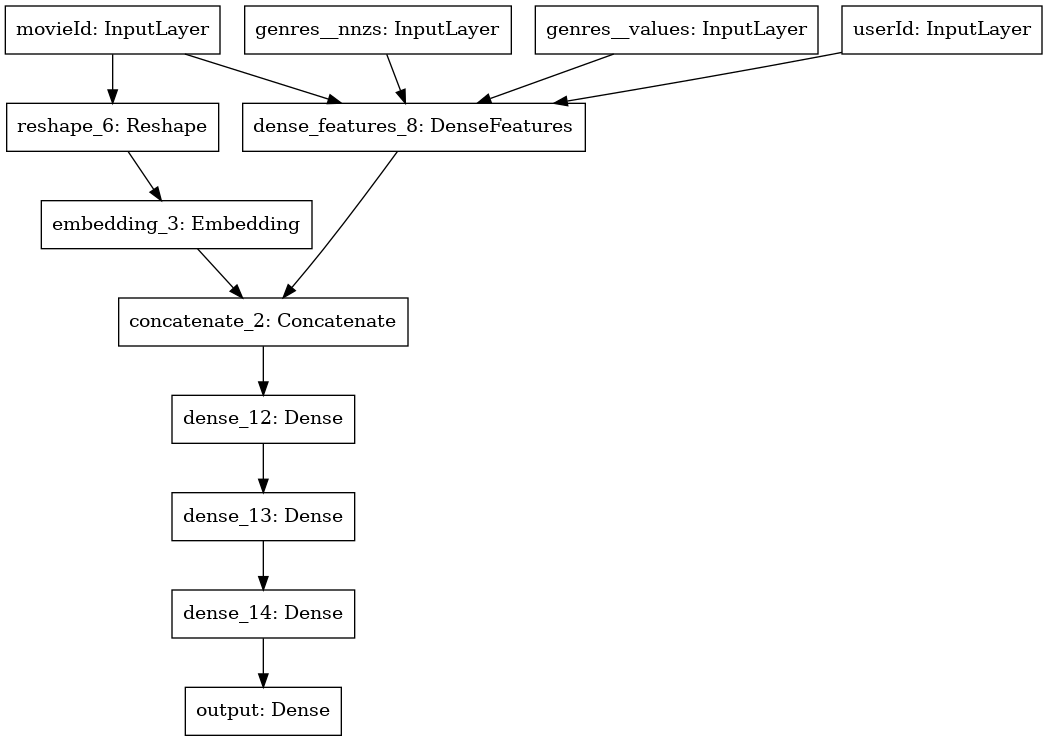

In [130]:
# You need to install the dependencies
tf.keras.utils.plot_model(model)

### Training the deep learning model

We can train our model with `model.fit`. We need to use a Callback to add the validation dataloader.

In [ ]:
validation_callback = KerasSequenceValidater(valid_dataset_tf)

history = model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=50)

Epoch 1/50
611/611 [==============================] - 41s 64ms/step - loss: 0.5273 - AUC: 0.7893
{'val_loss': 0.55516416, 'val_AUC': 0.7943459}
Epoch 2/50
611/611 [==============================] - 39s 62ms/step - loss: 0.4933 - AUC: 0.8205
{'val_loss': 0.52661306, 'val_AUC': 0.82041407}
Epoch 3/50
611/611 [==============================] - 39s 61ms/step - loss: 0.4844 - AUC: 0.8279
{'val_loss': 0.5194915, 'val_AUC': 0.8267972}
Epoch 4/50
611/611 [==============================] - 38s 61ms/step - loss: 0.4747 - AUC: 0.8356
{'val_loss': 0.5114968, 'val_AUC': 0.8330189}
Epoch 5/50
611/611 [==============================] - 38s 60ms/step - loss: 0.4649 - AUC: 0.8432
{'val_loss': 0.50313425, 'val_AUC': 0.83913755}
Epoch 6/50
611/611 [==============================] - 38s 60ms/step - loss: 0.4547 - AUC: 0.8510
{'val_loss': 0.49541005, 'val_AUC': 0.8447747}
Epoch 7/50
611/611 [==============================] - 37s 59ms/step - loss: 0.4447 - AUC: 0.8584
{'val_loss': 0.48725614, 'val_AUC': 0.8

In [ ]:
MODEL_NAME_TF = os.environ.get("MODEL_NAME_TF", "movielens_tf")
MODEL_PATH_TEMP_TF = os.path.join(MODEL_BASE_DIR, MODEL_NAME_TF, "1/model.savedmodel")

model.save(MODEL_PATH_TEMP_TF)

Before moving to the next notebook, `04a-Triton-Inference-with-TF.ipynb`, we need to generate the Triton Inference Server configurations and save the models in the correct format. We just saved TensorFlow model to disk, and in the previous notebook `02-ETL-with-NVTabular`, we saved the NVTabular workflow. Let's load the workflow. 

The TensorFlow input layers expect the input datatype to be int32. Therefore, we need to change the output datatypes to int32 for our NVTabular workflow.

In [ ]:
workflow = nvt.Workflow.load(os.path.join(INPUT_DATA_DIR, "workflow"))

workflow.output_dtypes["userId"] = "int32"
workflow.output_dtypes["movieId"] = "int32"

In [ ]:
MODEL_NAME_ENSEMBLE = os.environ.get("MODEL_NAME_ENSEMBLE", "movielens")
# model path to save the models
MODEL_PATH = os.environ.get("MODEL_PATH", os.path.join(MODEL_BASE_DIR, "models"))

NVTabular provides a function to save the NVTabular workflow, TensorFlow model and Triton Inference Server (IS) config files via `export_tensorflow_ensemble`. We provide the model, workflow, a model name for ensemble model, path and output column.

In [ ]:
# Creates an ensemble triton server model, where
#   model: The tensorflow model that should be served
#   workflow: The nvtabular workflow used in preprocessing
#   name: The base name of the various triton models

from nvtabular.inference.triton import export_tensorflow_ensemble

export_tensorflow_ensemble(model, workflow, MODEL_NAME_ENSEMBLE, MODEL_PATH, ["rating"])

Now, we can move to the next notebook, [04-Triton-Inference-with-TF.ipynb](https://github.com/NVIDIA/NVTabular/blob/main/examples/getting-started-movielens/04-Triton-Inference-with-TF.ipynb), to send inference request to the Triton IS.